<a href="https://colab.research.google.com/github/aruntahilramani/134_ArunTahilramani/blob/master/Lab%2011/134_PCA_SVM_EigenFaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


The eigenfaces example: chaining PCA and SVMs
=============================================

The goal of this example is to show how an unsupervised method and a
supervised one can be chained for better prediction. 

Here we'll take a look at a simple facial recognition example. Ideally,
we would use a dataset consisting of a subset of the `Labeled Faces in
the Wild <http://vis-www.cs.umass.edu/lfw/>`__ data that is available
with :func:`sklearn.datasets.fetch_lfw_people`. The labelled face in the wild face dataset.

However, this is a relatively large download (~200MB) so we will do the tutorial on a simpler, less rich dataset. 



In [1]:
from sklearn import datasets
faces = datasets.fetch_olivetti_faces()
faces.data.shape

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


(400, 4096)

Let's visualize these faces to see what we're working with

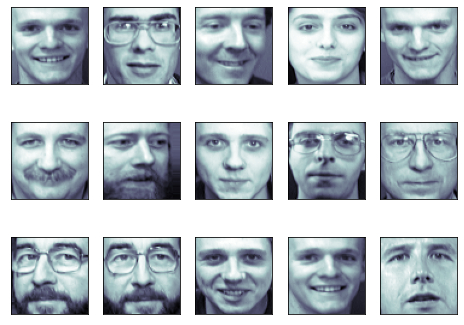

In [2]:
from matplotlib import pyplot as plt
import random
fig = plt.figure(figsize=(8, 6))
# plot several images
for i in range(15):
    r = random.randint(0, 400)
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(faces.images[r], cmap=plt.cm.bone)

Note is that these faces have already been localized and scaled to a common size. 
   
This is an important preprocessing piece for facial recognition, and is a process that can require a large collection of training data. 

This can be done in scikit-learn, but the challenge is gathering a sufficient amount of training data for the algorithm to work.

We'll perform a Support Vector classification of the images. We'll do a typical train-test split on the images:



In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(faces.data, faces.target, random_state=134
                                                    )
print(X_train.shape, X_test.shape)

(300, 4096) (100, 4096)


Preprocessing: Principal Component Analysis
-------------------------------------------

We can use PCA to reduce these features to a manageable size, while maintaining most of the information
in the dataset.



In [4]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=150, whiten=True)
pca.fit(X_train)

PCA(n_components=150, whiten=True)

One interesting part of PCA is that it computes the "mean" face, which
can be interesting to examine:



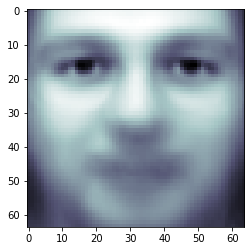

In [5]:
plt.imshow(pca.mean_.reshape(faces.images[0].shape), cmap=plt.cm.bone)

The principal components measure deviations about this mean along
orthogonal axes.



In [6]:
print(pca.components_.shape)

(150, 4096)


It is also interesting to visualize these principal components:



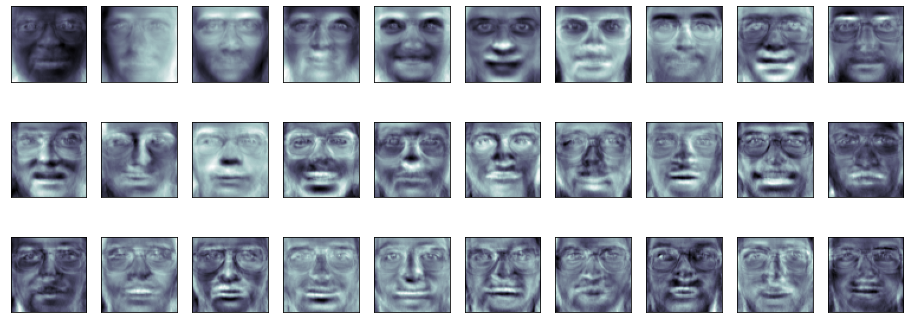

In [7]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(faces.images[0].shape),
              cmap=plt.cm.bone)

The components ("eigenfaces") are ordered by their importance from
top-left to bottom-right. We see that the first few components seem to
primarily take care of lighting conditions; the remaining components
pull out certain identifying features: the nose, eyes, eyebrows, etc.

With this projection computed, we can now project our original training
and test data onto the PCA basis:



In [8]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape)

(300, 150)


In [9]:
print(X_test_pca.shape)

(100, 150)


These projected components correspond to factors in a linear combination
of component images such that the combination approaches the original
face.

Doing the Learning: Support Vector Machines
-------------------------------------------

Now we'll perform support-vector-machine classification on this reduced
dataset:



In [10]:
from sklearn import svm
clf = svm.SVC(C=5., gamma=0.001)
clf.fit(X_train_pca, y_train)

SVC(C=5.0, gamma=0.001)

Finally, we can evaluate how well this classification did. First, we
might plot a few of the test-cases with the labels learned from the
training set:



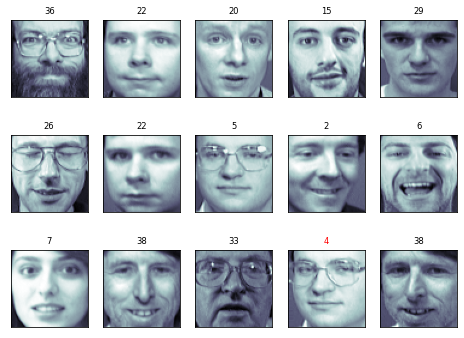

In [11]:
import numpy as np
fig = plt.figure(figsize=(8, 6))
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test[i].reshape(faces.images[0].shape),
              cmap=plt.cm.bone)
    y_pred = clf.predict(X_test_pca[i, np.newaxis])[0]
    color = ('black' if y_pred == y_test[i] else 'red')
    ax.set_title(y_pred, fontsize='small', color=color)

The classifier is correct on an impressive number of images given the
simplicity of its learning model! Using a linear classifier on 150
features derived from the pixel-level data, the algorithm correctly
identifies a large number of the people in the images.

Again, we can quantify this effectiveness using one of several measures
from :mod:`sklearn.metrics`. First we can do the classification
report, which shows the precision, recall and other measures of the
"goodness" of the classification:



In [12]:
from sklearn import metrics
y_pred = clf.predict(X_test_pca)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       0.50      1.00      0.67         1
           5       1.00      0.83      0.91         6
           6       1.00      0.80      0.89         5
           7       0.75      1.00      0.86         3
           8       1.00      1.00      1.00         3
           9       1.00      0.83      0.91         6
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         2
          12       0.00      0.00      0.00         0
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         4
          17       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Another interesting metric is the *confusion matrix*, which indicates
how often any two items are mixed-up. The confusion matrix of a perfect
classifier would only have nonzero entries on the diagonal, with zeros
on the off-diagonal:



In [13]:
print(metrics.confusion_matrix(y_test, y_pred))

[[2 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 2]]


Pipelining
----------

Above we used PCA as a pre-processing step before applying our support
vector machine classifier. Plugging the output of one estimator directly
into the input of a second estimator is a commonly used pattern; for
this reason scikit-learn provides a ``Pipeline`` object which automates
this process. The above problem can be re-expressed as a pipeline as
follows:



In [14]:
from sklearn.pipeline import Pipeline
clf = Pipeline([('pca', decomposition.PCA(n_components=150, whiten=True)),
                ('svm', svm.LinearSVC(C=1.0))])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(metrics.confusion_matrix(y_pred, y_test))
plt.show()

[[2 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 2]]
